# Logistic Regression Implementation

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions

## Metrics

In [3]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

    right_prediction = y_true == y_pred
    accuracy = right_prediction.sum() / len(y_true)
    return accuracy

def recall(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,0] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    recall = right_prediction.sum() / len(array)
    return recall

def precision(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,1] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    precision = right_prediction.sum() / len(array)

    return precision

def f1_score(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    precision_score = precision(y_true, y_pred)
    recall_score = recall(y_true, y_pred)

    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return f1_score

## Standardization

In [4]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Cross Validation

In [5]:
def kfolds_cross_validation(data, n_folds=10, shuffle=True, random_state=12894):
    indexes = np.arange(data.shape[0])
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(indexes)

    slices = np.array_split(indexes, n_folds)
    all_elements = np.hstack(slices)   
    
    splits = []
    for i in range(n_folds):
        train_idx = all_elements[~np.isin(all_elements, slices[i])]
        test_idx = slices[i]

        splits.append((train_idx, test_idx))

    return splits

## Train Test Split

In [6]:
def train_test_split(data, train_size_perc, random_seed=264852):
    N = data.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    train_data = data[train_idx]
    test_data = data[test_idx]

    X_train = train_data[:,:-1]
    y_train = train_data[:,[-1]]

    X_test = test_data[:,:-1]
    y_test = test_data[:,[-1]]

    return X_train, X_test, y_train, y_test

## Cross Validation and Get Metrics

In [7]:
def do_cv_and_get_metrics(classifier, cv_splits, X_train, y_train, X_test, title='Classifier', scaler=None):

    X_train = X_train.copy()
    y_train = y_train.copy()
    X_test = X_test.copy()

    train_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }

    valid_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }

    for train_idx, val_idx in cv_splits:
        # Spliting data
        X_train_cv = X_train[train_idx, :]
        y_train_cv = y_train[train_idx, :]
        X_val_cv = X_train[val_idx, :]
        y_val_cv = y_train[val_idx, :]

        # Scaling if have scaler argument
        if scaler is not None:
            X_train_cv = scaler.fit_transform(X_train_cv)
            X_val_cv = scaler.transform(X_val_cv)

        # Training Model
        classifier.fit(X_train_cv, y_train_cv.ravel())

        # Predictions
        y_train_cv_pred = classifier.predict(X_train_cv)
        y_val_cv_pred = classifier.predict(X_val_cv)

        # Storing metrics
        train_metrics['accuracy'].append(accuracy(y_train_cv, y_train_cv_pred))
        train_metrics['recall'].append(recall(y_train_cv, y_train_cv_pred))
        train_metrics['precision'].append(precision(y_train_cv, y_train_cv_pred))
        train_metrics['f1_score'].append(f1_score(y_train_cv, y_train_cv_pred))

        valid_metrics['accuracy'].append(accuracy(y_val_cv, y_val_cv_pred))
        valid_metrics['recall'].append(recall(y_val_cv, y_val_cv_pred))
        valid_metrics['precision'].append(precision(y_val_cv, y_val_cv_pred))
        valid_metrics['f1_score'].append(f1_score(y_val_cv, y_val_cv_pred))


    # Reporting results
    print('#' + f'{title}'.center(60, '-') + '#')
    print('\n--->\tTraining Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['accuracy']), 
        np.std(train_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(train_metrics['recall']), 
        np.std(train_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['precision']), 
        np.std(train_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['f1_score']), 
        np.std(train_metrics['f1_score']))
    )

    print('\n--->\tValidation Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['accuracy']), 
        np.std(valid_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(valid_metrics['recall']), 
        np.std(valid_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['precision']), 
        np.std(valid_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['f1_score']), 
        np.std(valid_metrics['f1_score']))
    )

    print('\n--->\tTest Metrics')

    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.ravel())
    y_test_pred = classifier.predict(X_test)

    print('Accuracy:     \t{0:.4f}'.format(accuracy(y_test, y_test_pred)))
    print('Recall:     \t{0:.4f}'.format(recall(y_test, y_test_pred)))
    print('Precision:     \t{0:.4f}'.format(precision(y_test, y_test_pred)))
    print('F1 Score:     \t{0:.4f}'.format(f1_score(y_test, y_test_pred)))


# Logistic Regression

In [8]:
data = np.genfromtxt('../data/breastcancer.csv', delimiter=',')
print('Shape:', data.shape)
data[:2,:]

Shape: (569, 31)


array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01,
        0.000e+00],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02,
        0.000e+00]])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, 0.8, random_seed=5482) #64825

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (455, 30)
y_train shape: (455, 1)
X_test shape: (114, 30)
y_test shape: (114, 1)


In [116]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def cross_entropy_loss(y, y_pred_proba):
    cost_1 = y.T @ np.log(y_pred_proba)
    cost_0 = (1-y).T @ np.log(1-y_pred_proba)
    j = -(1/len(y)) * (cost_1 + cost_0)
    return j.ravel()[0]

In [119]:
class MyLogisticRegression():
    def __init__(
        self, 
        alpha, 
        n_iterations
    ):        
        self.alpha = alpha        
        self.n_iterations = n_iterations

    def initialize(self, X, y, random_state=654812):
        rnd_state = np.random.RandomState(random_state)
        self.X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        self.y = y.reshape(-1, 1)

        self.w = np.zeros((np.shape(X)[1]+1,1))
        # self.w = rnd_state.uniform(0, 1, self.X.shape[1]).reshape(-1, 1)

    def fit(self, X, y, random_state=654812):
        
        if len(y.shape)==1:
            y = y.reshape(-1, 1)
            
        self.initialize(X, y, random_state)
        self.gradient_descent()

    def gradient_descent(self):
        self.loss_by_iteration = []
        for i in range(self.n_iterations):
            actual_y_pred_proba = sigmoid(self.X @ self.w)
            e = (self.y - actual_y_pred_proba) 
            
            grad = ((1/len(self.y)) * self.alpha * (e.T @ self.X))
            grad = grad.reshape(-1, 1)
            self.w = self.w + grad 
            

            new_y_pred_proba = sigmoid(self.X @ self.w)
            self.loss_by_iteration.append(
                cross_entropy_loss(self.y, new_y_pred_proba)
            )

    def predict_proba(self, X):
        X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        predict_proba = sigmoid(X @ self.w)
        return predict_proba

    def predict(self, X, threshold=0.5):
        X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        predict_proba = sigmoid(X @ self.w)
        predict_label = np.where(predict_proba>threshold, 1, 0)
        return predict_label



In [126]:
my_reg_log = MyLogisticRegression(alpha=0.001, n_iterations=10000)
do_cv_and_get_metrics(
    classifier=my_reg_log, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    scaler=StandardScaler(),
    title='My Logistic Regression'
)

#-------------------My Logistic Regression-------------------#

--->	Training Metrics
Accuracy Mean:     	0.9768 | Accuracy Std:   	0.0027
Recall Mean:     	0.9924 | Recall Std:       	0.0021
Precision Mean:     	0.9704 | Precision Std:   	0.0030
F1 Score Mean:     	0.9813 | F1 Score Std:   	0.0022

--->	Validation Metrics
Accuracy Mean:     	0.9757 | Accuracy Std:   	0.0232
Recall Mean:     	0.9924 | Recall Std:       	0.0153
Precision Mean:     	0.9694 | Precision Std:   	0.0309
F1 Score Mean:     	0.9805 | F1 Score Std:   	0.0190

--->	Test Metrics
Accuracy:     	1.0000
Recall:     	1.0000
Precision:     	1.0000
F1 Score:     	1.0000


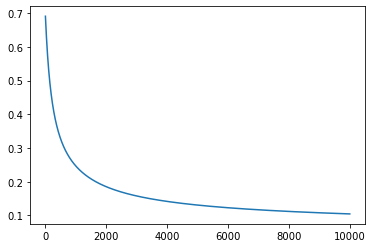

In [127]:
plt.plot(my_reg_log.loss_by_iteration)

In [125]:
# TO COMPARE
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
scaler = StandardScaler()
do_cv_and_get_metrics(
    classifier=reg_log, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    scaler=scaler,
    title='Sklearn Logistic Regression'
)

#----------------Sklearn Logistic Regression-----------------#

--->	Training Metrics
Accuracy Mean:     	0.9861 | Accuracy Std:   	0.0027
Recall Mean:     	0.9952 | Recall Std:       	0.0039
Precision Mean:     	0.9823 | Precision Std:   	0.0019
F1 Score Mean:     	0.9887 | F1 Score Std:   	0.0022

--->	Validation Metrics
Accuracy Mean:     	0.9735 | Accuracy Std:   	0.0217
Recall Mean:     	0.9848 | Recall Std:       	0.0306
Precision Mean:     	0.9729 | Precision Std:   	0.0245
F1 Score Mean:     	0.9784 | F1 Score Std:   	0.0193

--->	Test Metrics
Accuracy:     	0.9912
Recall:     	0.9872
Precision:     	1.0000
F1 Score:     	0.9935
